In [28]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

import torch
import torchdata.datapipes as dp
import torchvision
import torchmetrics
import pytorch_lightning as pl

from tqdm import tqdm
from hyperparameters import Hyperparameters
from datasets import ResiscDataModule, viz_batch

%load_ext dotenv
%dotenv

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
DATASET = Path.home() / "datasets" / "tiny-imagenet"

In [ ]:
@dp.functional_datapipe("load_image_label_pair")
class ImageLabelPairLoader(dp.iter.IterDataPipe):
    def __init__(self, source_datapipe, label_from_path: callable): ## type: ignore
        self.source_datapipe = source_datapipe
        self.label_from_path = label_from_path
    
    def __iter__(self):
        for file_name, file_stream in self.source_datapipe:
            yield (self._load_image(file_stream), 
                   self.label_from_path(file_name))

    def _load_image(self, image_path: Path) -> torch.Tensor:
        return torch.from_numpy(
            iio.imread(uri = image_path, 
                       #plugin = "pillow", 
                       extension = ".jpg")
                .astype(np.float32)
                .transpose(2, 0, 1))

@dp.functional_datapipe("apply_image_transforms")
class ImageTransformer(dp.iter.IterDataPipe):
    def __init__(self, source_datapipe, transforms = None) -> None:
        self.source_datapipe = source_datapipe
        self.transforms = transforms
    
    def __iter__(self):
        for image, annotation in self.source_datapipe:
            if self.transforms is not None:
                yield (self.transforms(image), annotation)
            else:
                yield (self._standard_transforms(image), annotation)
                
    def _standard_transforms(self, image: torch.Tensor):
        return torchvision.transforms.Resize(224, antialias=True)(image) / 255.0 # type: ignore

In [3]:
words = pd.read_table(DATASET / "words.txt", header=None)
words.columns = ["wnid", "words"]
words.set_index("wnid", inplace = True)

wnids = pd.read_table(DATASET / "wnids.txt", header=None)
wnids.columns = ["wnid"]

labels = words.loc[wnids.wnid].reset_index()
labels["words"] = labels["words"].apply(lambda x: x.lower())
labels

,wnid,words
0,n02124075,egyptian cat
1,n04067472,reel
2,n04540053,volleyball
3,n04099969,"rocking chair, rocker"
4,n07749582,lemon
...,...,...
195,n12267677,acorn
196,n03662601,lifeboat
197,n02841315,"binoculars, field glasses, opera glasses"
198,n07715103,cauliflower


In [49]:
words = pd.read_table(DATASET / "words.txt", header=None, index_col=0)
wnids = pd.read_table(DATASET / "wnids.txt", header=None, index_col=0)

labels = words.loc[wnids.index].reset_index()
labels.columns = ["wnid","words"]
labels["idx"] = np.arange(len(labels))
labels["words"] = labels["words"].str.split(",", expand = True)[0].str.lower()
labels.set_index(["wnid"], inplace = True)
labels

,words,idx
wnid,,
n02124075,egyptian cat,0
n04067472,reel,1
n04540053,volleyball,2
n04099969,rocking chair,3
n07749582,lemon,4
...,...,...
n12267677,acorn,195
n03662601,lifeboat,196
n02841315,binoculars,197


In [19]:
train = pd.DataFrame({"image": list((DATASET/"train").rglob("*.JPEG"))})
train.iloc[0][0]

/tmp/ipykernel_3676/3207506117.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train.iloc[0][0]


PosixPath('/home/sambhav/datasets/tiny-imagenet/train/n03100240/images/n03100240_211.JPEG')

In [120]:
def label_from_path(file_path: str) -> torch.Tensor:
    wnid = file_path.split("/")[-1].split("_")[0]
    return torch.tensor(labels.loc[wnid].idx)

train_dp = (dp.iter.FileLister(root = (DATASET/"train").as_posix(), 
                               recursive = True, masks = "*.JPEG")
            .shuffle(buffer_size = 100000)
            .open_files(mode = "b")
            .load_image_label_pair(label_from_path)
            .prefetch()
            .apply_image_transforms()
           )

Text(0.5, 0, 'orangutan')

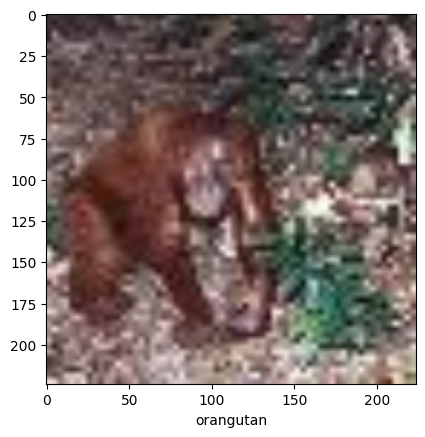

In [121]:
image, label = next(iter(train_dp))
plt.imshow(image.permute(1, 2, 0))
plt.xlabel(labels[labels.idx == label.item()].iloc[0].words)

In [10]:
len(pd.read_table((DATASET/"val"/"val_annotations.txt"), header = None))

10000